<a href="https://colab.research.google.com/github/yaminsu5674/StarGan_Studied/blob/main/StarGan_Milestone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import transforms as T
from torchvision.utils import save_image
from torchvision import datasets as dsets
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable

import os
import random
import time, datetime
import numpy as np

In [ ]:
downloaded_new= dsets.CelebA(root= './downloaded_new', split= 'train', target_type= 'attr', download= True)

In [ ]:
from zipfile import ZipFile

with ZipFile('/content/downloaded_new/celeba/img_align_celeba.zip', 'r') as zip:
    zip.extractall('temp')
    print('File is unzipped in temp folder')

In [ ]:
imgs_path= '/content/temp/img_align_celeba'
attrs_path= '/content/downloaded_new/celeba/list_attr_celeba.txt'

In [ ]:
selected_attrs= ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
attr2idx= {}
idx2attr= {}
train_dataset= []
test_dataset= []

In [ ]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [ ]:
lines= [line.rstrip() for line in open(attrs_path, 'r')]
print(lines[0])

202599


In [ ]:
all_attr_names= lines[1].split()
for i, attr_name in enumerate(all_attr_names):
    attr2idx[attr_name]= i
    idx2attr[i]= attr_name

print(idx2attr)

{0: '5_o_Clock_Shadow', 1: 'Arched_Eyebrows', 2: 'Attractive', 3: 'Bags_Under_Eyes', 4: 'Bald', 5: 'Bangs', 6: 'Big_Lips', 7: 'Big_Nose', 8: 'Black_Hair', 9: 'Blond_Hair', 10: 'Blurry', 11: 'Brown_Hair', 12: 'Bushy_Eyebrows', 13: 'Chubby', 14: 'Double_Chin', 15: 'Eyeglasses', 16: 'Goatee', 17: 'Gray_Hair', 18: 'Heavy_Makeup', 19: 'High_Cheekbones', 20: 'Male', 21: 'Mouth_Slightly_Open', 22: 'Mustache', 23: 'Narrow_Eyes', 24: 'No_Beard', 25: 'Oval_Face', 26: 'Pale_Skin', 27: 'Pointy_Nose', 28: 'Receding_Hairline', 29: 'Rosy_Cheeks', 30: 'Sideburns', 31: 'Smiling', 32: 'Straight_Hair', 33: 'Wavy_Hair', 34: 'Wearing_Earrings', 35: 'Wearing_Hat', 36: 'Wearing_Lipstick', 37: 'Wearing_Necklace', 38: 'Wearing_Necktie', 39: 'Young'}


In [ ]:
lines= lines[2:]
random.seed(23)
random.shuffle(lines)

for i, line in enumerate(lines):
    split= line.split()
    filename= split[0]
    values= split[1:]

    label= []
    for attr_name in selected_attrs:
        idx= attr2idx[attr_name]
        label.append(values[idx] == '1')

    if (i+ 1) < 2000:
        test_dataset.append([filename, label])
    else:
        train_dataset.append([filename, label])


In [ ]:
class CelebA(data.Dataset):
    def __init__(self, mode = 'train', transform= None):
        self.dataset= train_dataset if mode == 'train' else test_dataset
        self.num_images= len(self.dataset)
        self.transform= transform
        
    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        filename, label= self.dataset[idx]
        img= Image.open(os.path.join(imgs_path, filename))
        return self.transform(img), torch.FloatTensor(label)

In [ ]:
def CelebA_Loader(mode= 'train'):
    transform= []
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
    transform.append(T.CenterCrop(178))
    transform.append(T.Resize(128))
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean= (0.5, 0.5, 0.5), std= (0.5, 0.5, 0.5)))

    transforms= T.Compose(transform)

    dataset_celeba= CelebA(mode= mode, transform= transforms)

    loader= data.DataLoader(dataset= dataset_celeba,
    batch_size= 16,
    shuffle= (mode=='train'),)
    
    return loader

In [ ]:
# --------------------------------------------Model Designing----------------------------------------------

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main= nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size= 3, stride= 1, padding= 1, bias= False),
            nn.InstanceNorm2d(dim_out, affine= True, track_running_stats= True),
            nn.ReLU(inplace= True),
            nn.Conv2d(dim_in, dim_out, kernel_size= 3, stride= 1, padding= 1, bias= False),
            nn.InstanceNorm2d(dim_out, affine= True, track_running_stats= True)
        )

    def forward(self, x):
        return x + self.main(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, conv_dim= 64, c_dim= 5, repeat_num= 6):
        super(Generator, self).__init__()

        layers= []
        layers.append(nn.Conv2d(3+ c_dim, conv_dim, kernel_size= 7, stride= 1, padding= 3, bias= False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine= True, track_running_stats= True))
        layers.append(nn.ReLU(inplace= True))

        curr_dim= conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size= 4, stride= 2, padding= 1, bias= False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine= True, track_running_stats= True))
            layers.append(nn.ReLU(inplace= True))
            curr_dim= curr_dim*2

        for i in range(repeat_num):
            layers.append(ResidualBlock(curr_dim, curr_dim))

        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size= 4, stride= 2, padding= 1, bias= False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine= True, track_running_stats= True))
            layers.append(nn.ReLU(inplace= True))
            curr_dim= curr_dim//2

        layers.append(nn.Conv2d(curr_dim, 3, kernel_size= 7, stride= 1, padding= 3, bias= False))
        layers.append(nn.Tanh())

        self.layers= nn.Sequential(*layers)

    def forward(self, x, c):
        c= c.view(c.size(0), c.size(1), 1, 1)
        c_hat= c.repeat(1, 1, x.size(2), x.size(3))
        inputs= torch.cat([x, c_hat], dim= 1)
        return self.layers(inputs)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_size= 128, conv_dim= 64, c_dim= 5, repeat_num= 6):
        super(Discriminator, self).__init__()
        layers= []
        layers.append(nn.Conv2d(3, conv_dim, kernel_size= 4, stride= 2, padding= 1))
        layers.append(nn.LeakyReLU(0.01))

        curr_dim= conv_dim
        for i in range(1, repeat_num):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size= 4, stride= 2, padding= 1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim= curr_dim*2

        kernel_size= int(img_size/ np.power(2, repeat_num))
        self.layers= nn.Sequential(*layers)
        self.conv1= nn.Conv2d(curr_dim, 1, kernel_size=3, stride= 1, padding= 1, bias= False)
        self.conv2= nn.Conv2d(curr_dim, c_dim, kernel_size= kernel_size, bias= False)

    def forward(self, x):
        h= self.layers(x)
        out_src= self.conv1(h)
        out_cls= self.conv2(h)
        return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))

In [ ]:
G= Generator().to(device)
D= Discriminator().to(device)

In [ ]:
g_optimizer= optim.Adam(G.parameters(), 0.0001, [0.5, 0.999])
d_optimizer= optim.Adam(D.parameters(), 0.0001, [0.5, 0.999])

In [ ]:
def resotre_model(model_G, model_D, G_path, D_path):
  G= model_G
  D= model_D
  print('Loading teh trained models..')
  G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
  D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))
  

In [ ]:
def update_lr(g_lr, d_lr):
    for param_group in g_optimizer.param_groups:
        param_gropu['lr']= g_lr
    for param_group in d_optimizer.param_groups:
        param_group['lr']= d_lr


In [ ]:
def reset_grad():
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

In [ ]:
def denorm(x):
    out= (x+1)/2
    return out.clamp_(0, 1)

In [ ]:
def gradient_penalty(y, x):
    weight= torch.ones(y.size()).to(device)
    dydx= torch.autograd.grad(outputs= y,
    inputs= x,
    grad_outputs= weight,
    retain_graph= True,
    create_graph= True,
    only_inputs= True)[0]

    dydx= dydx.view(dydx.size(0), -1)
    dydx_l2norm= torch.sqrt(torch.sum(dydx**2, dim= 1))
    return torch.mean((dydx_l2norm- 1)**2)

In [ ]:
def classification_loss(logit, target):
    return F.binary_cross_entropy_with_logits(logit, target, size_average= False) / logit.size(0)

In [ ]:
training_epochs= 200000
loading= CelebA_Loader()
data_iter= iter(loading)

In [ ]:
'''test_k, test_k2= next(data_iter)
print(test_k.size(), test_k2.size())
test_k= test_k.to(device)
test_k2= test_k2.to(device)'''

torch.Size([16, 3, 128, 128]) torch.Size([16, 5])


In [ ]:
'''urasia= G(test_k, test_k2)
urasia.size()'''

torch.Size([16, 3, 8, 8])

In [ ]:
for i in range(training_epochs):
    ori_img, ori_label= next(data_iter)

    rand_idx= torch.randperm(ori_label.size(0))
    trg_label= ori_label[rand_idx]

    ori_img= ori_img.to(device)
    ori_label= ori_label.to(device)
    trg_label= trg_label.to(device)

    # -----------------Discrdiminator Training-------------------------

    out_src, out_cls= D(ori_img)
    d_loss_real= -torch.mean(out_src)
    d_loss_cls= classification_loss(out_cls, ori_label)

    x_fake= G(ori_img, trg_label)
    out_src, out_cls= D(x_fake.detach())
    d_loss_fake= torch.mean(out_src)

    alpha= torch.rand(ori_img.size(0), 1, 1, 1).to(device)
    x_hat= (alpha * ori_img.data + (1-alpha) * x_fake.data).requires_grad_(True)
    out_src, _= D(x_hat)
    d_loss_gp= gradient_penalty(out_src, x_hat)



    d_loss= d_loss_real + d_loss_fake + 1 * d_loss_cls + 10 * d_loss_gp
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    loss = {}
    loss['D/loss_real'] = d_loss_real.item()
    loss['D/loss_fake'] = d_loss_fake.item()
    loss['D/loss_cls'] = d_loss_cls.item()
    loss['D/loss_gp'] = d_loss_gp.item() 


    #-------------------------------Generator Training-----------------------

    if (i+1) % 5 == 0 :
        x_fake= G(ori_img, trg_label)
        out_src, out_cls= D(x_fake)
        g_loss_fake= -torch.mean(out_src)
        g_loss_cls= classification_loss(out_cls, trg_label)

        x_reconst= G(x_fake, ori_label)
        g_loss_rec= torch.mean(torch.abs(ori_img - x_reconst))


        g_loss= g_loss_fake + 10 * g_loss_rec + 1 * g_loss_cls
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        loss['G/loss_fake'] = g_loss_fake.item()
        loss['G/loss_rec'] = g_loss_rec.item()
        loss['G/loss_cls'] = g_loss_cls.item()

    if (i+1) %200 == 0 and (i+1) != 1:
        print('G_loss : {}   ,   D_loss : {}'.format(g_loss, d_loss))
    

    if (i+1) % 1000 == 0 and (i+1) > (training_epochs - 100000):
        g_lr-= g_lr / float(100000)
        d_lr-= d_lr / float(100000)
        update_lr(g_lr, d_lr)
        print('Decayed learning rates, g_lr: {}, d_lr: {}'.format(g_lr, d_lr))

In [ ]:
model_save_dir= '/content/temp'


In [ ]:
G_path = os.path.join(model_save_dir, '{}-G.ckpt'.format(1))
D_path = os.path.join(model_save_dir, '{}-D.ckpt'.format(1))
torch.save(G.state_dict(), G_path)
torch.save(D.state_dict(), D_path)
print('Saved model checkpoints into {}...'.format(model_save_dir))

Saved model checkpoints into /content/temp...


In [ ]:
G_1= Generator().to(device)
D_1= Discriminator().to(device)

In [ ]:
G_path= '/content/drive/MyDrive/Trained_Models/1-G.ckpt'
D_path= '/content/drive/MyDrive/Trained_Models/1-D.ckpt'
resotre_model(G_1, D_1, G_path, D_path )

Loading teh trained models..


In [ ]:
#------------------------test-----------------------

['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']

In [ ]:
test_loader= CelebA_Loader(mode= 'test')

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
test_iter= iter(test_loader)

fake_list= []
with torch.no_grad():
    img, label= next(test_iter)
    print(label)
    img= img.to(device)
    label= label.to(device)

    fake= G_1(img, label)
    fake_list.append(fake)


tensor([[1., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [1., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1.]])


In [ ]:
img.shape

torch.Size([16, 3, 128, 128])

In [ ]:
haha= img[4]

In [ ]:
haha.shape

torch.Size([3, 128, 128])

In [ ]:
def tensor2original(img):
  img= img.clone().detach().cpu()
  img= np.array(img).transpose(1,2,0)
  img*= 255
  img= img.astype(np.uint8)
  return img

In [ ]:
onebon= tensor2original(denorm(haha))


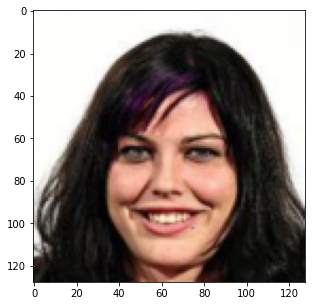

In [ ]:
plt.figure(figsize= (5,5))
plt.imshow(onebon)

In [ ]:
with torch.no_grad():

  result= G_1(torch.unsqueeze(haha, 0).to(device), torch.unsqueeze(torch.Tensor([1,0,0,1,1]), 0).to(device))

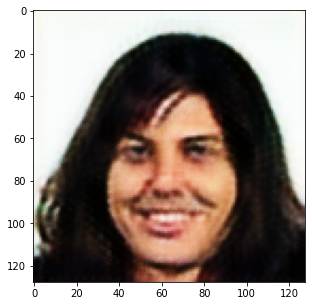

In [ ]:
wow= result.squeeze(0)
wow= tensor2original(denorm(wow))
plt.figure(figsize=(5,5))
plt.imshow(wow)